<center>
    <h3> Real-Time Time Dependent Orbital Free Density Functional Theory with DFTpy</h3>
    <h3>Tutorial</h3>
</center>
<table>
  <tr>
      <td><p><h4>Rutgers University-Newark</h4></p><p>Dr Xuecheng Shao</p><p>Dr Kaili Jiang (Microsoft)</p><p>Dr. Bhaskar Rana</p><p>Jessica Martinez</p><p>Valeria Rios </p><p>Alina Umerbekova</p></td>
          <td><img src="../figures/logos/logo.jpg" width=800 /></td>
  </tr>
</table>

ASESMA

## Goal
#### 1) Obtain the Optical Spectra (plasmons) of a Mg<sub>8</sub> cluster using DFTpy
#### 2) Obtain the spectrum of your own cluster

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick
from dftpy.ions import Ions
from dftpy.formats import io
from dftpy.constants import Units
from dftpy.td.utils import calc_spectra_mu

In [3]:
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF

--2025-06-03 21:27:09--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
Resolving gitlab.com (gitlab.com)... 172.65.251.78
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839 [text/plain]
Saving to: ‘Mg8.vasp.1’

Mg8.vasp.1          100%[===================>]     839  --.-KB/s    in 0s      

2025-06-03 21:27:09 (53.3 MB/s) - ‘Mg8.vasp.1’ saved [839/839]

--2025-06-03 21:27:09--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF
Resolving gitlab.com (gitlab.com)... 172.65.251.78
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98081 (96K) [text/plain]
Saving to: ‘Mg_OEPP_PZ.UPF.1’

Mg_OEPP_PZ.UPF.1    100%[===================>]  95.78K  --.-KB/s    in 0.09s   

2025-06-03 21:27:10 (1.00 MB/s) - ‘Mg_OEPP_PZ.UPF.1’ saved [98081/98081]



### Read the vasp file with DFTpy

In [4]:
ions = io.read('Mg8.vasp', format='vasp', names=['Mg'])

### Create the PP list and the Grid
DirectGrid is a class object that represents a grid (Cell plus discretization)

In [5]:
PP_list = ['./Mg_OEPP_PZ.UPF']
grid = DirectGrid(ions.cell, spacing = 1.1)

In [6]:
grid.nr

array([36, 36, 32], dtype=int32)

### Define the functionals for OF-DFT

In [7]:
ke = Functional(type='KEDF',name='TFvW')
xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list)
totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)

setting key: Mg -> ./Mg_OEPP_PZ.UPF


### Represented a field on a grid
Write on the grid the initial electronic density

In [8]:
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

### Write the optimization options and build the class that handles the electron density optimization

In [9]:
optimization_options = {'econv' : 1e-9,'maxiter' : 100}

opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')

#### Run the optimization of the electronic density

In [10]:
 rho0 = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.951916882520E+00      8.951917E+00    2.343046E+00    1       1       2.931881E-02    
!WARN: Change to steepest decent
1       -4.970850195117E+00     -1.392277E+01   1.121758E+00    1       3       5.821085E-02    
2       -5.991894359401E+00     -1.021044E+00   1.516348E-01    4       2       9.523201E-02    
3       -6.128065564511E+00     -1.361712E-01   1.802914E-02    8       3       1.752219E-01    
4       -6.143827132639E+00     -1.576157E-02   3.111799E-03    10      3       2.470579E-01    
5       -6.146022420271E+00     -2.195288E-03   3.902282E-04    7       3       3.016038E-01    
6       -6.146449722646E+00     -4.273024E-04   4.586762E-05    10      3       3.698828E-01    
7       -6.146493565256E+00     -4.384261E-05   6.805996E-06    7       3       4.211619E-01    
8       -6.146501642729E+00     -8.077473E-06   7.757266E-07    10      2       4.819310E-01  

In [32]:
rho0.write(filename="rho_tfvw.xsf", ions=ions)

# Time dependent part
### Remove the von Wäzecker KEDF
Change the KE functional in the total functional to Pauli functional, the laplacian is handled by the hamiltonian
$$
[-\frac{1}{2}\nabla ^2 + v_B(\mathbf{r},t)]\phi_B(\mathbf{r},t) = \mu \phi_B(\mathbf{r},t)
$$
$$
v_B(\mathbf{r},t)= v_s(\mathbf{r})+v_p(\mathbf{r},t)+v_{appl}(\mathbf{r},t)
$$
$$
v_p(\mathbf{r},t) = v_{Ts}(\mathbf{r},t) - v_{vW}(\mathbf{r},t)
$$

In [11]:
ke.options.update({'y':0})

In [12]:
from dftpy.constants import TIME_CONV, LEN_CONV, ENERGY_CONV
as2au = TIME_CONV['s']['au']*1e-18
bohr = LEN_CONV['Angstrom']['Bohr']
k = 0.01*bohr
interval = 1.0 * as2au
ha = ENERGY_CONV['Hartree']['eV']

In [13]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively

## Run with Crank Nicholson propagator

In [14]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        print("\r", end="")
        print(f"Progress: [{self.nsteps+1}/{self.max_steps}]", "|" * (self.nsteps*50 // self.max_steps), end="", flush=True)

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [23]:
max_steps = 5000
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

Progress: [5000/5000] |||||||||||||||||||||||||||||||||||||||||||||||||

False

In [24]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
mu = np.asarray(runner.dipole)

## Plot the dipole moment

Text(0, 0.5, 'Dipole Moment (au)')

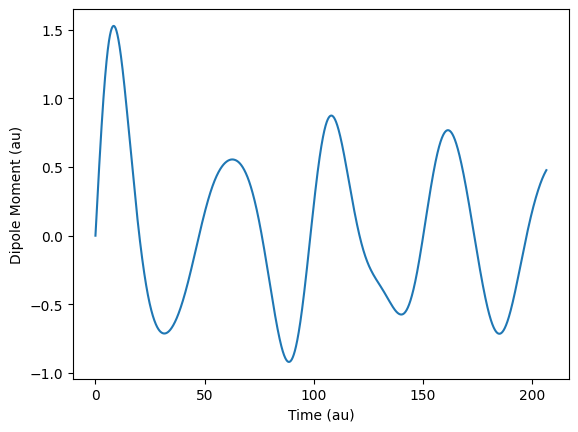

In [25]:
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

## Plot the optical spectra

(0.0, 20.0)

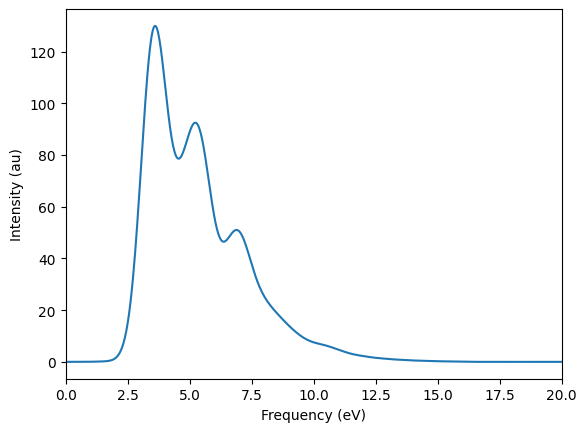

In [27]:
sigma = 0.1*(as2au**2)
omega, spectra = calc_spectra_mu(delta_mu, interval, sigma=sigma, kick=k)
plt.plot(omega*Units.Ha, spectra, '-')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 20)

## Challenge 

Calculate the optical spectra of your own cluster

### Build a cluster with ASE


In [28]:
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [2, 2, 2]
lc = 3.61000
atoms = FaceCenteredCubic('Mg', surfaces, layers, latticeconstant=lc)
atoms.set_cell([10,10,10])
atoms.wrap()
atoms.center(vacuum=10.0)

In [29]:
atoms.get_global_number_of_atoms()

19

In [30]:
import py3Dmol
from ase.build import bulk
from ase.io import write
from ase.constraints import FixBondLength
write('cluster.xyz',atoms)
v = py3Dmol.view(data=open('./cluster.xyz','r').read(), style='sphere',linked=False)
v.addUnitCell()
v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [22]:
from dftpy.formats.io import Ions
ions = Ions.from_ase(atoms)